<a href="https://colab.research.google.com/github/Yfyangd/BMIR/blob/master/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Library

In [1]:
# manipulate with numpy,load with panda
import numpy as np
import pandas as pd
from os.path import join as opj
# data visualization
import cv2
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2. Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.listdir("/content/drive/My Drive/Iceberg")

['image.json']

In [0]:
train = pd.read_json('../content/drive/My Drive/Iceberg/image.json')
#making a copy of the main train dataset
data=train.copy()
#creating a dataframe from band_1 and band_2 columns in train set.
band_1_df=pd.DataFrame(i for i in data['band_1'])
band_2_df=pd.DataFrame(i for i in data['band_2'])
#converting `inc_angle` to numeric values.
data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')

Is_iceberg  is_iceberg    753
dtype: int64
Not_iceberg  is_iceberg    851
dtype: int64


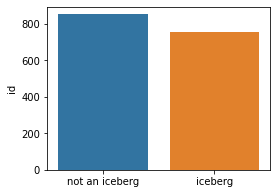

In [5]:
is_iceberg_1_df = pd.DataFrame(data['is_iceberg'])
Isiceberg=is_iceberg_1_df.sum()
print("Is_iceberg ", Isiceberg)
print("Not_iceberg ", (1604-Isiceberg))
f,ax = plt.subplots(1,1,figsize=(4,3))
sns.barplot(x=['not an iceberg','iceberg'],y=train.groupby(['is_iceberg'],as_index=False).count()['id'])
plt.show()

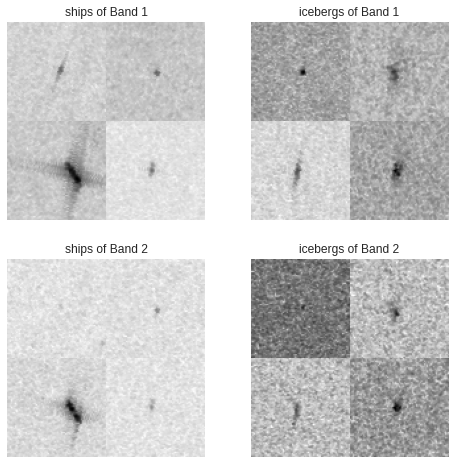

In [40]:
train_images = train.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
train_images = np.stack(train_images).squeeze()

from skimage.util import montage
fig, (ax1s, ax2s) = plt.subplots(2,2, figsize = (8,8))
obj_list = dict(ships = train.query('is_iceberg==0').sample(4).index,
     icebergs = train.query('is_iceberg==1').sample(4).index)
for ax1, ax2, (obj_type, idx_list) in zip(ax1s, ax2s, obj_list.items()):
    ax1.imshow(montage(train_images[idx_list,:,:,0]))
    ax1.set_title('%s of Band 1' % obj_type)
    ax1.axis('off')
    ax2.imshow(montage(train_images[idx_list,:,:,1]))
    ax2.set_title('%s of Band 2' % obj_type)
    ax2.axis('off')

In [0]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])

In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=10,
            b=15,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_1[12,:,:], 'iceberg')

In [8]:
plotmy3d(X_band_1[14,:,:], 'Ship')

## 3. Data Preprocess

In [0]:
def get_scaled_imgs(df):
    imgs = []
    
    for i, row in df.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = (band_1 + band_2)/2
        # Normalize
        a = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        b = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        c = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())
        imgs.append(np.dstack((a, b, c)))

    return np.array(imgs)

In [0]:
Xtrain_CNN = get_scaled_imgs(train)
Ytrain_CNN = np.array(train['is_iceberg'])

## 4. Model_AlexNet

In [11]:
# Import Keras 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


<img style="float: left;" src="alexnet.png" width="90%">

In [0]:
def AlexNet():
    model=Sequential()
    # CNN 1
    model.add(Conv2D(96,(11,11),strides=(4,4),input_shape=(75,75,3),
                     padding='valid',activation='relu',kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    # CNN 2
    model.add(Conv2D(256,(5,5),strides=(1,1),
                     padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    # CNN 3
    model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    # CNN 4
    model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    # CNN 5
    model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    # Flatten
    model.add(Flatten())
    #Dense 1
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.5))
    #Dense 2
    model.add(Dense(4096,activation='relu'))
    model.add(Dropout(0.5))
    #output layer
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
    model.summary()
    return model

In [19]:
model = AlexNet()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 17, 17, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 384)         885120    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 3, 384)         1327488   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 256)        

## 5. Model Training
### 5.1 Without Data Augmentation

In [20]:
batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning:

`epsilon` argument is deprecated and will be removed, use `min_delta` instead.



In [21]:
# Split the 'features' and 'income' data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xtrain_CNN, Ytrain_CNN, random_state=1, train_size=0.80)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1283 samples.
Testing set has 321 samples.


In [22]:
train_hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=40, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

Train on 962 samples, validate on 321 samples
Epoch 1/40
962/962 [==============================] - 1s 635us/step - loss: 0.6926 - accuracy: 0.4969 - val_loss: 0.6876 - val_accuracy: 0.5514
Epoch 2/40
962/962 [==============================] - 0s 449us/step - loss: 0.6908 - accuracy: 0.5208 - val_loss: 0.6839 - val_accuracy: 0.5514
Epoch 3/40
962/962 [==============================] - 0s 437us/step - loss: 0.6892 - accuracy: 0.5374 - val_loss: 0.6814 - val_accuracy: 0.5514
Epoch 4/40
962/962 [==============================] - 0s 447us/step - loss: 0.6869 - accuracy: 0.5291 - val_loss: 0.6790 - val_accuracy: 0.5514
Epoch 5/40
962/962 [==============================] - 0s 449us/step - loss: 0.6839 - accuracy: 0.5364 - val_loss: 0.6764 - val_accuracy: 0.5514
Epoch 6/40
962/962 [==============================] - 0s 459us/step - loss: 0.6828 - accuracy: 0.5333 - val_loss: 0.6738 - val_accuracy: 0.5514
Epoch 7/40
962/962 [==============================] - 0s 453us/step - loss: 0.6785 - accur

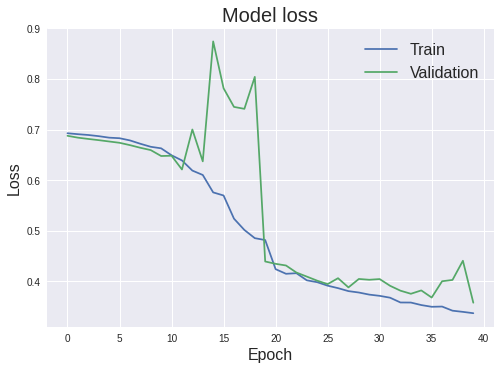

In [23]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.plot(train_hist.history['loss'])
plt.plot(train_hist.history['val_loss'])
plt.title('Model loss',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize=16)
plt.show()

In [0]:
# Performance function
def performance_model(prediction,y_test):
    # Get Label in array
    list = []
    for i in y_test:
        list.append(i)
    arr = np.arange(len(y_test)).reshape(len(y_test),1)
    np.place(arr, arr>=0, list)
    # TN: True Nagetive, TP: True Positive, FP: False Positive, FN: False Nagetive
    i = 0
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    while i < len(y_test):
        if prediction[i,0] == arr[i,0]:
            if prediction[i,0] == 0:
                TN += 1
            else:
                TP += 1
        else:
            if prediction[i,0] == 1:
                FP += 1
            else:
                FN += 1
        i += 1
    #  Accuracy (ACC), precision (PR), recall (RC),and F-score(FS)
    ACC = (TN+TP)/(TN+TP+FP+FN)
    PR = TP/(TP+FP)
    RC = TP/(TP+FN)
    FS = 2*(PR*RC)/(PR+RC)
    return(ACC,PR,RC,FS)

In [25]:
prediction = model.predict_classes(X_test)
ACC,PR,RC,FS = performance_model(prediction,y_test)
print('Accuracy: ',ACC)
print('Precision:',PR)
print('Recall: ',RC)
print('F-score: ',FS)

Accuracy:  0.8629283489096573
Precision: 0.8273809523809523
Recall:  0.9025974025974026
F-score:  0.8633540372670807


### 5.2 With Data Augmentation

In [0]:
def data_augmentation(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [0]:
Xtrain_more = data_augmentation(Xtrain_CNN) 
Ytrain_more = np.concatenate((Ytrain_CNN,Ytrain_CNN,Ytrain_CNN))

In [31]:
model2 = AlexNet()
model2.summary()

batch_size = 32
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts2.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 17, 17, 96)        34944     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 256)         614656    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 3, 3, 384)         885120    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 3, 384)         1327488   
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 3, 3, 256)        

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning:

`epsilon` argument is deprecated and will be removed, use `min_delta` instead.



In [32]:
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xtrain_more, Ytrain_more, random_state=1, train_size=0.80)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 1283 samples.
Testing set has 321 samples.


In [33]:
train_hist2 = model2.fit(X_train2, y_train2, batch_size=batch_size, epochs=40, verbose=1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], validation_split=0.25)

Train on 2886 samples, validate on 963 samples
Epoch 1/40
2886/2886 [==============================] - 1s 496us/step - loss: 0.6915 - accuracy: 0.5114 - val_loss: 0.6858 - val_accuracy: 0.5472
Epoch 2/40
2886/2886 [==============================] - 1s 426us/step - loss: 0.6874 - accuracy: 0.5489 - val_loss: 0.6837 - val_accuracy: 0.6303
Epoch 3/40
2886/2886 [==============================] - 1s 421us/step - loss: 0.6812 - accuracy: 0.5610 - val_loss: 0.6713 - val_accuracy: 0.5628
Epoch 4/40
2886/2886 [==============================] - 1s 429us/step - loss: 0.6702 - accuracy: 0.5790 - val_loss: 0.6532 - val_accuracy: 0.6334
Epoch 5/40
2886/2886 [==============================] - 1s 425us/step - loss: 0.6474 - accuracy: 0.6268 - val_loss: 0.6172 - val_accuracy: 0.6158
Epoch 6/40
2886/2886 [==============================] - 1s 421us/step - loss: 0.6021 - accuracy: 0.6736 - val_loss: 0.6172 - val_accuracy: 0.6345
Epoch 7/40
2886/2886 [==============================] - 1s 424us/step - loss:

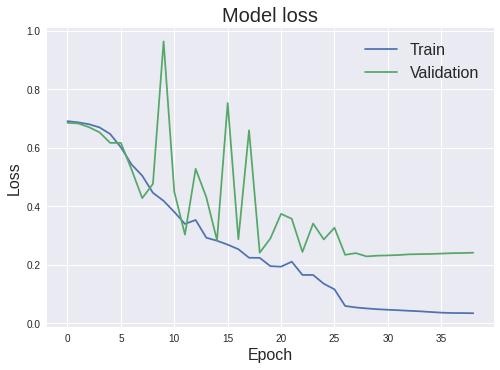

In [34]:
plt.style.use('seaborn')
plt.plot(train_hist2.history['loss'])
plt.plot(train_hist2.history['val_loss'])
plt.title('Model loss',fontsize=20)
plt.ylabel('Loss',fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.legend(['Train', 'Validation'], loc='upper right',fontsize=16)
plt.show()

In [35]:
prediction2 = model2.predict_classes(X_test2)
ACC,PR,RC,FS = performance_model(prediction2,y_test2)
print('Accuracy: ',ACC)
print('Precision:',PR)
print('Recall: ',RC)
print('F-score: ',FS)

Accuracy:  0.8909657320872274
Precision: 0.8671023965141612
Recall:  0.9004524886877828
F-score:  0.8834628190899001


The accruacy of AlexNet with data augmentation is 0.8909 more than the model without data augmentation (0.8629)